<a href="https://colab.research.google.com/github/szeshiang/Advanced-Computer-Vision/blob/main/300624_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Develop a multi-class model using CNN

In [1]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import shutil
shutil.unpack_archive('seg_train.zip')
shutil.unpack_archive('seg_test.zip')

In [4]:
# import the library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_dataset_path='/content/seg_train'
test_dataset_path='/content/seg_test'
print('data loaded')

data loaded


Data Augmentation

In [7]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

train_datagen=ImageDataGenerator(rescale=1./255,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [8]:
train_generator=train_datagen.flow_from_directory(train_dataset_path,
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',shuffle=True)

Found 14034 images belonging to 6 classes.


In [9]:
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_directory(test_dataset_path,
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',shuffle=True)

Found 3000 images belonging to 6 classes.


Get the Label Mapping

In [10]:
labels={value:key for key,value in train_generator.class_indices.items()}
print(labels)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


Visualisation

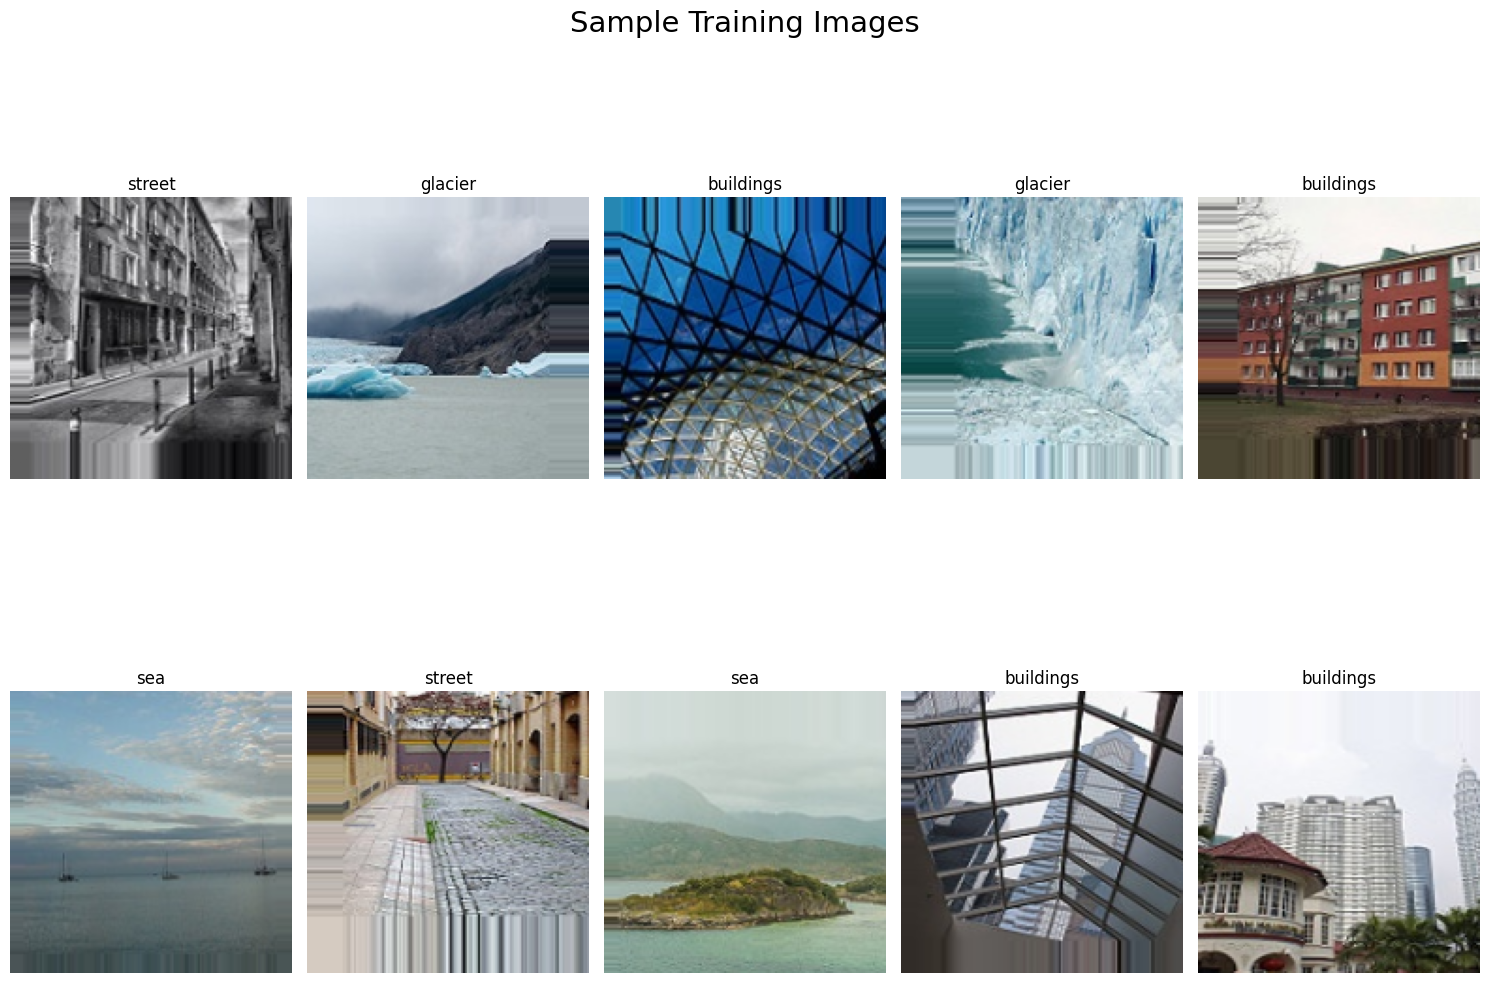

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Create the CNN Architecture
1. Number of layers
2. Number of filers; kernel shape (matrix size), activation fn
3. Maxpooling, dropout or not
4. ANN layers

for this exercise - 3 layers of CNN, 2 dense layers in ANN

In [12]:
def create_model():
  model=Sequential()
  model.add(Conv2D(128,(5,5),activation='relu',padding='valid',input_shape=(IMG_WIDTH,IMG_HEIGHT,3))) # just need input once input shape
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(32,(3,3),activation='relu',padding='valid'))
  model.add(MaxPooling2D(pool_size=(2,2)))  # 3 x CNN layers created

  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6,activation='softmax'))
  return model
  model.add(Dense(len(labels),activation='softmax'))

In [14]:
cnn_model=create_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

first CNN layer = 150

next input shape = output shape-kernel size+1 = 150-5+1 = 146;

146/2=73 (dimension=shape is reduced, but because maxpooling has no learning hence the weights remained (128, 64, 32)

for the next input shape: 73-3+1=71

Compile the model

In [15]:
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
# taining the model
history=cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
439/439 [==============================] - 117s 248ms/step - loss: 1.1538 - accuracy: 0.5423 - val_loss: 0.9092 - val_accuracy: 0.6477
Epoch 2/10
439/439 [==============================] - 103s 235ms/step - loss: 0.9178 - accuracy: 0.6453 - val_loss: 0.8727 - val_accuracy: 0.6623
Epoch 3/10
439/439 [==============================] - 108s 245ms/step - loss: 0.8028 - accuracy: 0.6989 - val_loss: 0.6066 - val_accuracy: 0.7873
Epoch 4/10
439/439 [==============================] - 108s 245ms/step - loss: 0.7197 - accuracy: 0.7317 - val_loss: 0.6494 - val_accuracy: 0.7630
Epoch 5/10
439/439 [==============================] - 108s 247ms/step - loss: 0.6668 - accuracy: 0.7557 - val_loss: 0.5530 - val_accuracy: 0.8087
Epoch 6/10
439/439 [==============================] - 108s 245ms/step - loss: 0.6309 - accuracy: 0.7728 - val_loss: 0.5273 - val_accuracy: 0.8117
Epoch 7/10
439/439 [==============================] - 109s 248ms/step - loss: 0.6030 - accuracy: 0.7796 - val_loss: 0.5179 -

In [17]:
# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(validation_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

94/94 [==============================] - 6s 58ms/step - loss: 0.4579 - accuracy: 0.8327
Test Loss: 0.4579210877418518
Test Accuracy: 0.8326666951179504


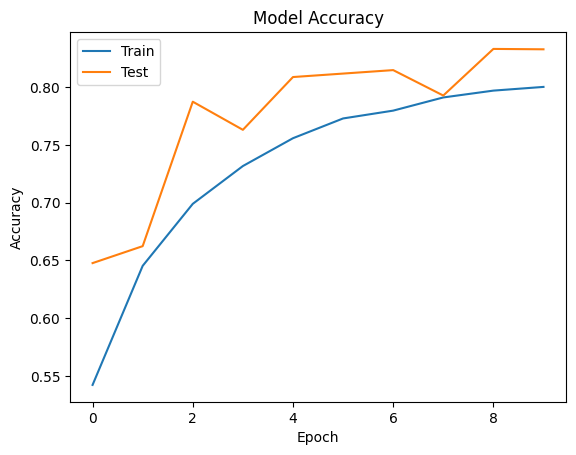

In [18]:
# plot the train accuracy vs test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
# save the model
cnn_model.save('cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# load the cnn model
cnn_model=tf.keras.models.load_model('cnn_model.h5')
print('model saved')

model saved


Prediction

In [21]:
prediction=cnn_model.predict(validation_generator)

94/94 [==============================] - 4s 37ms/step


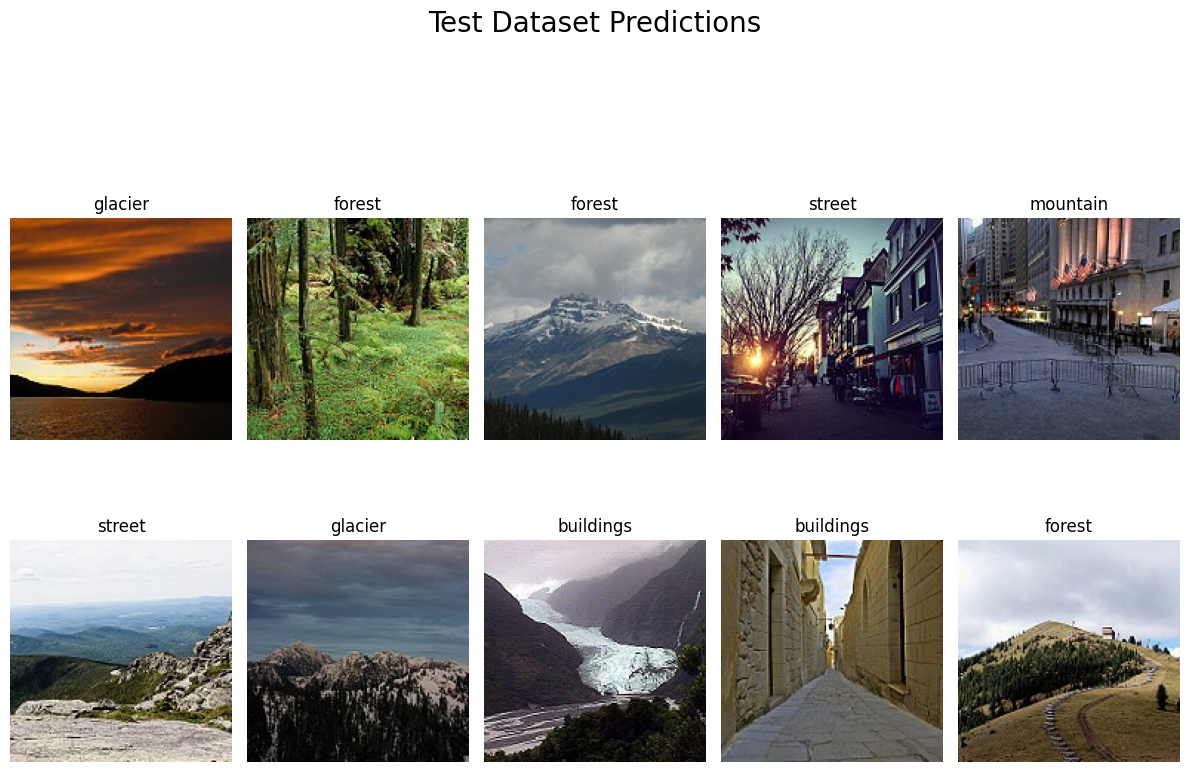

In [27]:
# show prediction on some images from validation data
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(prediction[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(validation_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1
        plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


Create Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
prediction

array([[8.25572119e-04, 4.48702551e-08, 9.56311107e-01, 4.13658842e-02,
        1.20432675e-03, 2.93109333e-04],
       [2.01407911e-05, 9.99874949e-01, 9.02101237e-05, 1.30517183e-05,
        5.64525294e-07, 1.09595783e-06],
       [1.08067561e-02, 9.87143695e-01, 4.95539280e-05, 1.50448955e-06,
        1.93920343e-07, 1.99825224e-03],
       ...,
       [4.88102529e-03, 9.77611899e-01, 1.68413841e-04, 2.21029932e-05,
        4.61172976e-06, 1.73119102e-02],
       [3.01640830e-03, 1.22278125e-03, 1.21916547e-01, 8.48499656e-01,
        1.97767131e-02, 5.56791387e-03],
       [2.88352668e-01, 4.81634494e-03, 4.27115522e-02, 5.22041321e-01,
        2.45489795e-02, 1.17529094e-01]], dtype=float32)

In [28]:
y_pred = np.argmax(prediction, axis=1)
y_true = validation_generator.classes

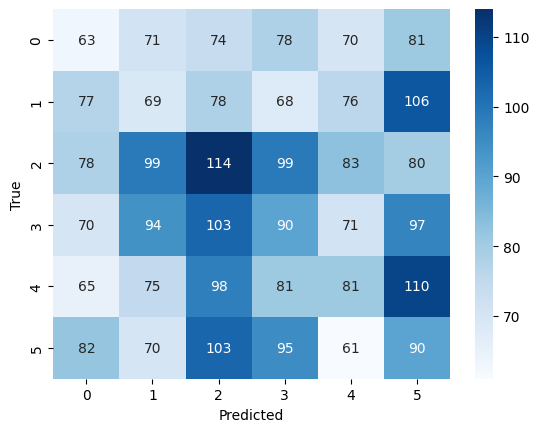

In [29]:
# create a confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()